###  Importing some useful libraries

In [28]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics 
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline 
# It sets the backend of matplotlib to the 'inline' backend:
import time # calculate time 

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

* **Loading the main dataset.**

In [29]:
phish_data = pd.read_csv('phishing_site_urls.csv')

#### download dataset from my **Kaggle**  <a href='https://www.kaggle.com/taruntiwarihp/phishing-site-urls'>here</a>

In [30]:
phish_data.head()

URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad

In [31]:
phish_data.tail()

URL Label
549341     23.227.196.215/   bad
549342  apple-checker.org/   bad
549343   apple-iclods.org/   bad
549344  apple-uptoday.org/   bad
549345   apple-search.info   bad

In [32]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


* **About dataset**
* Data is containg 5,49,346 unique entries.
* There are two columns.
* Label column is prediction col which has 2 categories 
    A. Good - which means the urls is not containing malicious stuff and **this site is not a Phishing Site.**
    B. Bad - which means the urls contains malicious stuffs and **this site isa Phishing Site.**
* There is no missing value in the dataset.

In [33]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [34]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

<AxesSubplot:ylabel='Label'>

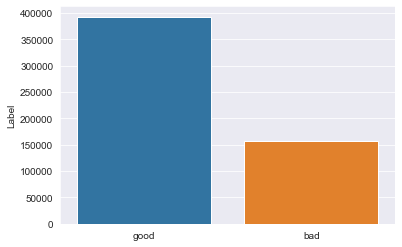

In [35]:
#visualizing target_col
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

### Preprocessing

* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [36]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [37]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [38]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [39]:
print('Getting words tokenized ...')

phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows

Getting words tokenized ...


In [40]:
phish_data.sample(5)

URL Label  \
141188  akira-jav.com/peach-028-pink-seisyun-woman-sch...  good   
254478  v1019.radio.com/2011/11/08/its-the-day-bourbon...  good   
113919                        got-mick.com/xmlpcn/mailbox   bad   
470141  youjizz.com/videos/megan-leigh-and-tom-byron-1...  good   
39716   us.battle.net-d3-tw.account-eu.com/battle_net_...   bad   

                                           text_tokenized  
141188  [akira, jav, com, peach, pink, seisyun, woman,...  
254478  [v, radio, com, its, the, day, bourbon, whiske...  
113919                  [got, mick, com, xmlpcn, mailbox]  
470141  [youjizz, com, videos, megan, leigh, and, tom,...  
39716   [us, battle, net, d, tw, account, eu, com, bat...

#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [41]:
stemmer = SnowballStemmer("english") # choose a language

In [42]:
print('Getting words stemmed ...')
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

Getting words stemmed ...


In [43]:
phish_data.sample(5)

URL Label  \
384061      manta.com/ic/mt609yj/ca/charbonneau-dr-france  good   
94964           opansdctiles.tripod.com/dctiles/index.htm  good   
360392                          imdb.com/title/tt0368563/  good   
193887                                  glendaleacne.com/  good   
391015  monmouthmedicalgroup.com/internal-medicine-md....  good   

                                           text_tokenized  \
384061  [manta, com, ic, mt, yj, ca, charbonneau, dr, ...   
94964    [opansdctiles, tripod, com, dctiles, index, htm]   
360392                             [imdb, com, title, tt]   
193887                                [glendaleacne, com]   
391015  [monmouthmedicalgroup, com, internal, medicine...   

                                             text_stemmed  
384061  [manta, com, ic, mt, yj, ca, charbonneau, dr, ...  
94964       [opansdctil, tripod, com, dctile, index, htm]  
360392                              [imdb, com, titl, tt]  
193887                                 [glendaleacn, com]  
391015  [monmouthmedicalgroup, com, intern, medicin, m...

In [44]:
print('Getting joiningwords ...')
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))

Getting joiningwords ...


In [45]:
phish_data.sample(5)

URL Label  \
354924  hotud.org/component/content/article/44-war/19794  good   
433389         songarea.com/music-codes/dj_champion.html  good   
84344      www.iplanet.com/products/iplanet_application/  good   
245866                tfc.american-soccer-news.com/?p=30  good   
233126         radio-weblogs.com/0101170/2008/04/19.html  good   

                                           text_tokenized  \
354924     [hotud, org, component, content, article, war]   
433389  [songarea, com, music, codes, dj, champion, html]   
84344   [www, iplanet, com, products, iplanet, applica...   
245866              [tfc, american, soccer, news, com, p]   
233126                        [radio, weblogs, com, html]   

                                            text_stemmed  \
354924        [hotud, org, compon, content, articl, war]   
433389  [songarea, com, music, code, dj, champion, html]   
84344      [www, iplanet, com, product, iplanet, applic]   
245866             [tfc, american, soccer, news, com, p]   
233126                        [radio, weblog, com, html]   

                                       text_sent  
354924       hotud org compon content articl war  
433389  songarea com music code dj champion html  
84344     www iplanet com product iplanet applic  
245866            tfc american soccer news com p  
233126                     radio weblog com html

### Visualization 
**1. Visualize some important keys using word cloud**

In [46]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [47]:
bad_sites.head()

URL Label  \
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad   
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad   
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad   
3  mail.printakid.com/www.online.americanexpress....   bad   
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad   

                                      text_tokenized  \
0  [nobell, it, ffb, d, dca, cce, f, login, SkyPe...   
1  [www, dghjdgf, com, paypal, co, uk, cycgi, bin...   
2  [serviciosbys, com, paypal, cgi, bin, get, int...   
3  [mail, printakid, com, www, online, americanex...   
4  [thewhiskeydregs, com, wp, content, themes, wi...   

                                        text_stemmed  \
0  [nobel, it, ffb, d, dca, cce, f, login, skype,...   
1  [www, dghjdgf, com, paypal, co, uk, cycgi, bin...   
2  [serviciosbi, com, paypal, cgi, bin, get, into...   
3  [mail, printakid, com, www, onlin, americanexp...   
4  [thewhiskeydreg, com, wp, content, theme, wide...   

                                           text_sent  
0  nobel it ffb d dca cce f login skype com en cg...  
1  www dghjdgf com paypal co uk cycgi bin webscrc...  
2  serviciosbi com paypal cgi bin get into herf s...  
3  mail printakid com www onlin americanexpress c...  
4  thewhiskeydreg com wp content theme widescreen...

In [48]:
good_sites.head()

URL Label  \
18231  esxcc.com/js/index.htm?us.battle.net/noghn/en/...  good   
18232  wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...  good   
18233  'www.institutocgr.coo/web/media/syqvem/dk-óij...  good   
18234                  Yìê
koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í  good   
18236  ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...  good   

                                          text_tokenized  \
18231  [esxcc, com, js, index, htm, us, battle, net, ...   
18232  [www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...   
18233  [www, institutocgr, coo, web, media, syqvem, d...   
18234                                  [Y, ko, D, l, qt]   
18236  [ruta, fm, com, images, AS, Vies, i, cf, b, vc...   

                                            text_stemmed  \
18231  [esxcc, com, js, index, htm, us, battl, net, n...   
18232  [www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...   
18233  [www, institutocgr, coo, web, media, syqvem, d...   
18234                                  [y, ko, d, l, qt]   
18236  [ruta, fm, com, imag, as, vie, i, cf, b, vc, f...   

                                               text_sent  
18231  esxcc com js index htm us battl net noghn en r...  
18232  www eira nvinip nch wv ydah ye u rt u g m i xz...  
18233  www institutocgr coo web media syqvem dk ij r ...  
18234                                        y ko d l qt  
18236  ruta fm com imag as vie i cf b vc f d b g sd v...

* create a function to visualize the important keys from url 

In [49]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [50]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

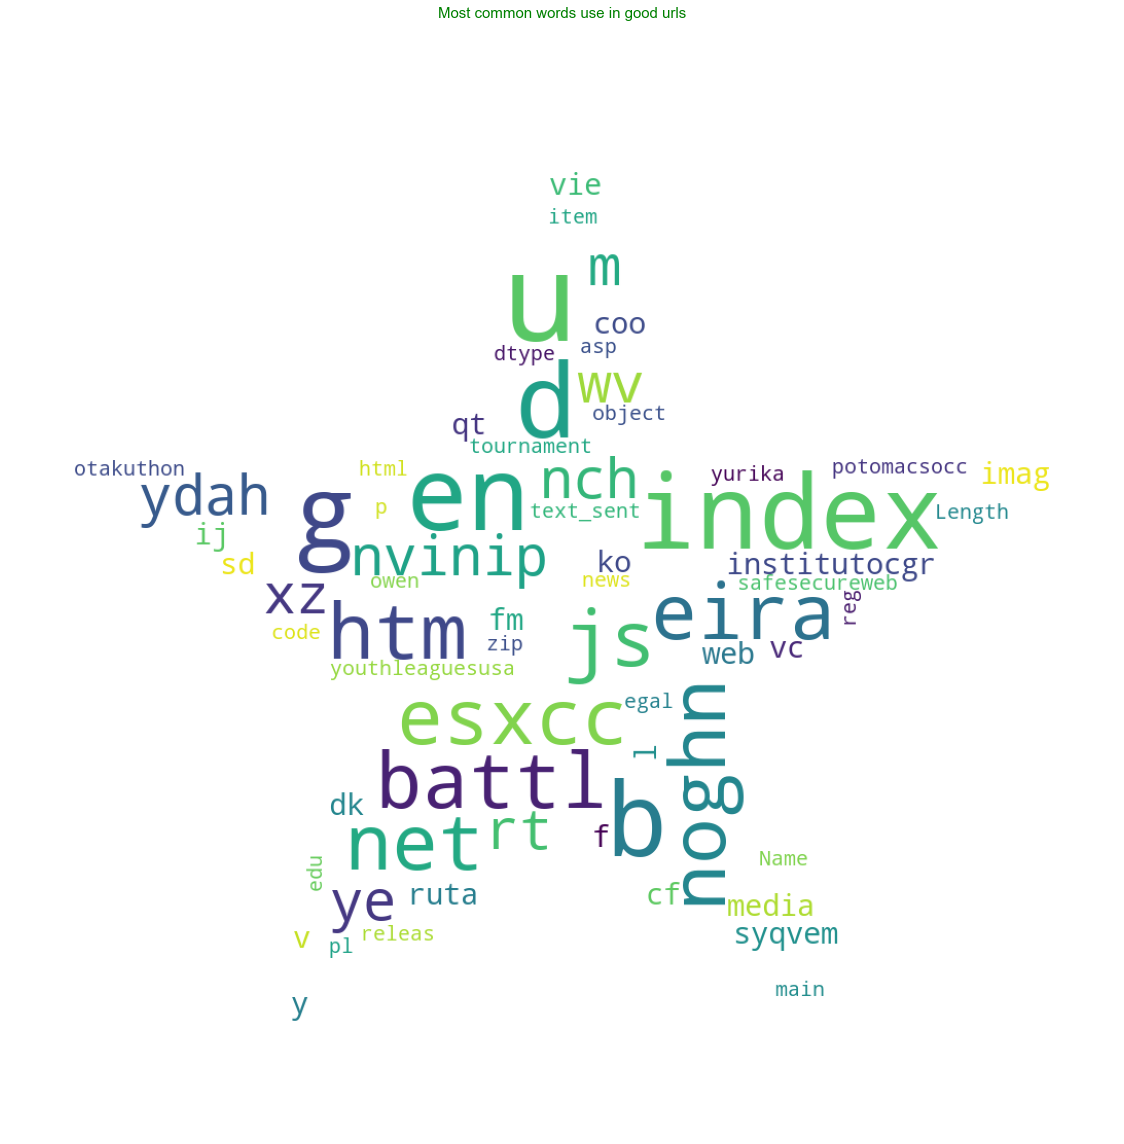

In [51]:
common_text = str(data)
common_mask = np.array(Image.open('star.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, 
               title = 'Most common words use in good urls', title_size=15)

In [52]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

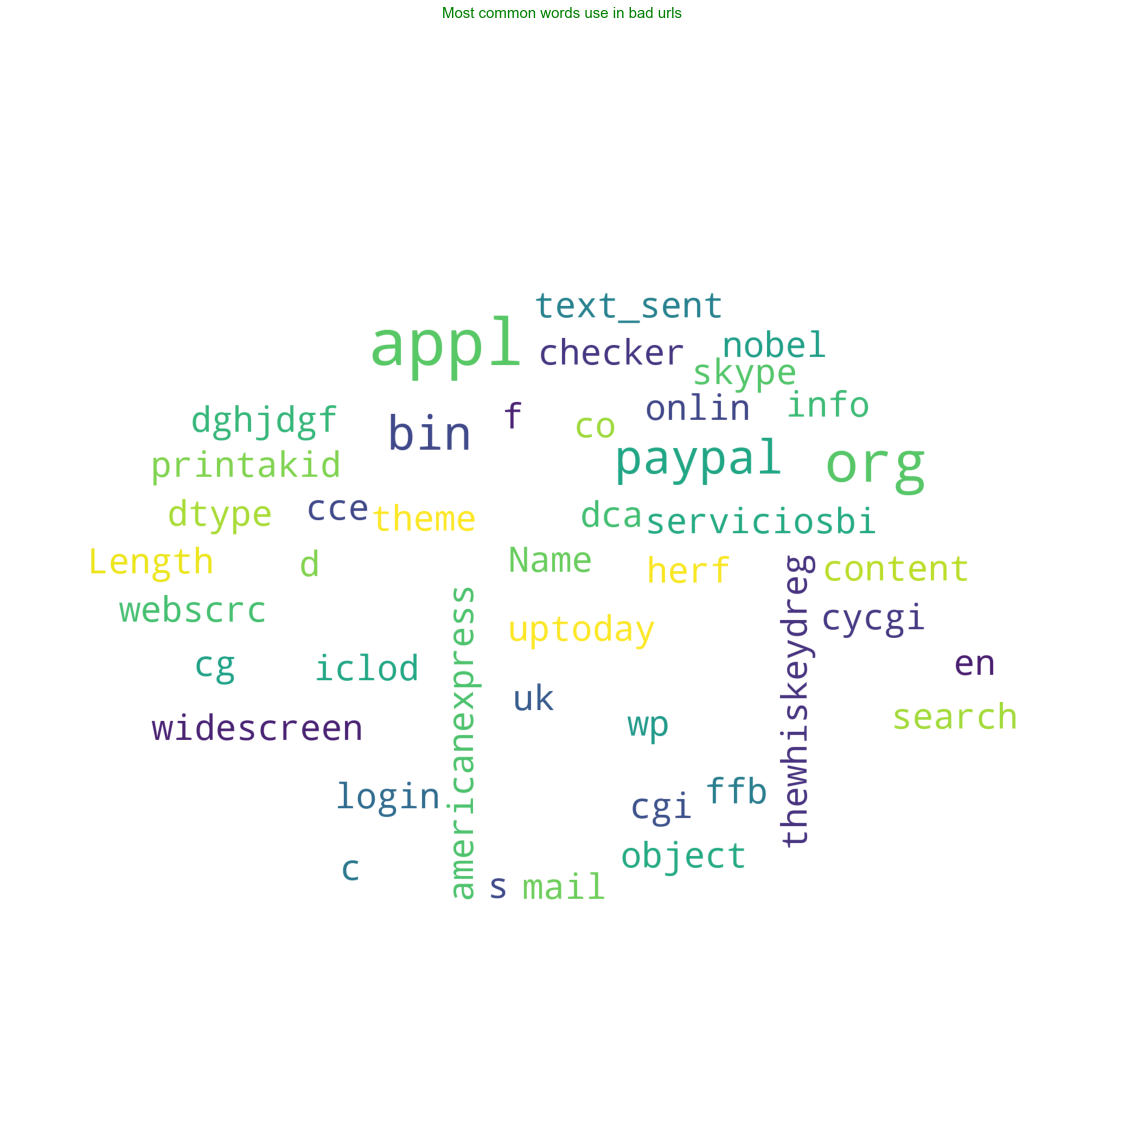

In [53]:
common_text = str(data)
common_mask = np.array(Image.open('comment.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, 
               title = 'Most common words use in bad urls', title_size=15)

Download more various type of images <a href='https://github.com/taruntiwarihp/raw_images/tree/master/Words%20cloud%20images'>here</a>

**2. Visualize internal links, it will shows all redirect links.** 

#### Scrape any website
* First, setting up the Chrome webdriver so we can scrape dynamic web pages.

#### Chrome webdriver
* WebDriver tool use for automated testing of webapps across many browsers. It provides capabilities for navigating to web pages, user input and more

In [54]:
browser = webdriver.Chrome(executable_path=r"C:\Users\Asus\Downloads\chromedriver_win32\chromedriver")

WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://chromedriver.chromium.org/home


**You can download chromedriver.exe from my github <a href='https://github.com/taruntiwarihp/dataSets/blob/master/chromedriver_win32.zip'>here</a>**

* After set up the Chrome driver create two lists.
* First list named list_urls holds all the pages you’d like to scrape.
* Second, create an empty list where you’ll append links from each page.


In [ ]:
list_urls = ['https://www.republicworld.com/topics/filmy4wap'] #here i take phishing sites 
links_with_text = []

* I took some phishing site to see were the hackers redirect(on different link) us.
* Use the BeautifulSoup library to extract only relevant hyperlinks for Google, i.e. links only with '<'a'>' tags with href attributes. 

#### BeautifulSoup
* It is use for getting data out of HTML, XML, and other markup languages. 

In [ ]:
for url in list_urls:
    browser.get(url)
    soup = BeautifulSoup(browser.page_source,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

#### Turn the URL’s into a Dataframe
* After you get the list of your websites with hyperlinks turn them into a Pandas DataFrame with columns “from” (URL where the link resides) and “to” (link destination URL)

In [ ]:
df = pd.DataFrame(links_with_text, columns=["from", "to"])

In [ ]:
df.head()

from  \
0  https://www.republicworld.com/topics/filmy4wap   
1  https://www.republicworld.com/topics/filmy4wap   
2  https://www.republicworld.com/topics/filmy4wap   
3  https://www.republicworld.com/topics/filmy4wap   
4  https://www.republicworld.com/topics/filmy4wap   

                                             to  
0  https://www.republicworld.com/privacy-policy  
1                                          None  
2             https://bharat.republicworld.com/  
3                https://www.republicworld.com/  
4     https://www.republicworld.com/livetv.html

#### Step 3: Draw a graph
* Finally, use the aforementioned DataFrame to **visualize an internal link structure by feeding it to the Networkx method from_pandas_edgelist first** and draw it by calling nx.draw

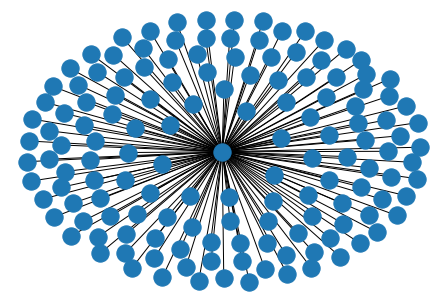

In [ ]:
GA = nx.from_pandas_edgelist(df, source="from", target="to")
nx.draw(GA, with_labels=False)

### Creating Model

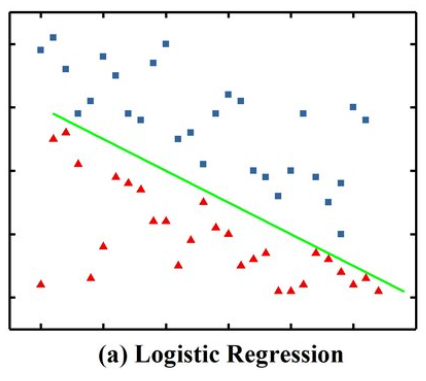

* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.


#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [ ]:
#create cv object
cv = CountVectorizer()

In [ ]:
#help(CountVectorizer())

In [ ]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [ ]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### * Spliting the data 

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression


In [ ]:
# create lr object
lr = LogisticRegression()

In [ ]:
lr.fit(trainX,trainY)

LogisticRegression()

In [ ]:
lr.score(testX,testY)

0.9652824803221273

Training Accuracy : 0.9800174268037835
Testing Accuracy : 0.9652824803221273

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36813
        Good       0.99      0.97      0.98    100524

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<AxesSubplot:>

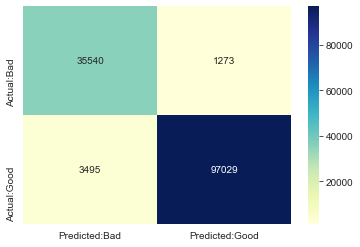

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [ ]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_ls.score(testX,testY) 

0.9674159185070301

Training Accuracy : 0.9816605947928322
Testing Accuracy : 0.9674159185070301

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.97      0.94     37187
        Good       0.99      0.97      0.98    100150

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<AxesSubplot:>

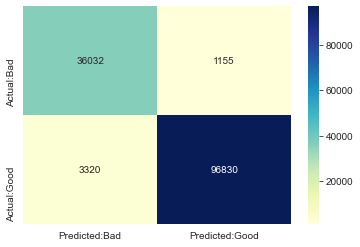

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.966731470761703


***That’s it. See, it's that simple yet so effective. We get an accuracy of 98%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

* Bad links => this are phishing sites
yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php
fazan-pacir.rs/temp/libraries/ipad
www.tubemoviez.exe
svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

* Good links => this are not phishing sites
www.youtube.com/
youtube.com/watch?v=qI0TQJI3vdU
www.retailhellunderground.com/
restorevisioncenters.com/html/technology.html

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']


https://research.aalto.fi/en/datasets/phishstorm-phishing-legitimate-url-dataset

In [ ]:
predict_bad = ['https://www.geeksforgeeks.org/python-program-to-convert-a-list-to-string/']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.predict(predict_bad)
print(result)


['good']
